In [2]:
pip install torch==2.2.0

  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvjitlink_cu12-12.3.101-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 943.1 kB/s eta 0:00:000:0100:04m
Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
Using cached n

In [3]:
pip install torchvision==0.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 10.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 932.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 886.5 kB/s eta 0:00:00a 0:00:01
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.1/715.1 kB 4.9 MB/s eta 0:00:0000:0100:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 936.1 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
import torch
import copy
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn.functional as F
import cv2
import os
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.features = mobilenet_v2.features
        for param in self.features.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        return self.features(x)

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, norm_type='batchnorm', apply_dropout=False):
        super(UpSampleBlock, self).__init__()
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if norm_type.lower() == 'batchnorm':
            layers.append(nn.BatchNorm2d(out_channels))
        if apply_dropout:
            layers.append(nn.Dropout(0.5))
        layers.append(nn.ReLU(inplace=True))
        self.upsample = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.upsample(x)
class MobileNetV2_UNet(nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNetV2_UNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = nn.Sequential(
            UpSampleBlock(1280, 512, apply_dropout=True),
            UpSampleBlock(512, 256),
            UpSampleBlock(256, 128),
            UpSampleBlock(128, 64),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # 출력 크기 조정
        x = F.interpolate(x, size=(960, 544), mode='bilinear', align_corners=False)
        return x
    
class ResizeTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, mask):
        image = transforms.Resize(self.size)(image)
        mask = transforms.Resize(self.size, interpolation=transforms.InterpolationMode.NEAREST)(mask)
        return image, mask
    
    

class CustomTransform:
    def __init__(self):
        self.resize = transforms.Resize((960, 544))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __call__(self, image, mask):
        image = self.resize(image)
        image = self.to_tensor(image)
        image = self.normalize(image)

        # 마스크는 크기만 조정하고, 텐서로 변환합니다. Normalize는 적용하지 않습니다.
        mask = self.resize(mask)
        mask = torch.from_numpy(np.array(mask, dtype=np.int64))
        return image, mask
    
# 데이터셋 정의
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_mask.png'))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


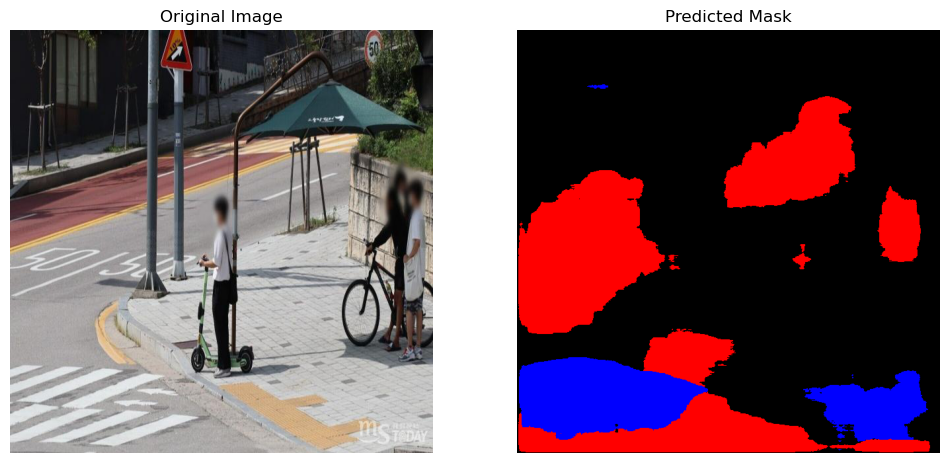


image 1/1 /home/pjs/workspace/SEJONG/bicycle-human-3/train/images/10_jpg.rf.867d4ab7685fb3d993b0a1b6774bdcf9.jpg: 640x640 1 kickboard-human, 908.5ms
Speed: 1.7ms preprocess, 908.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


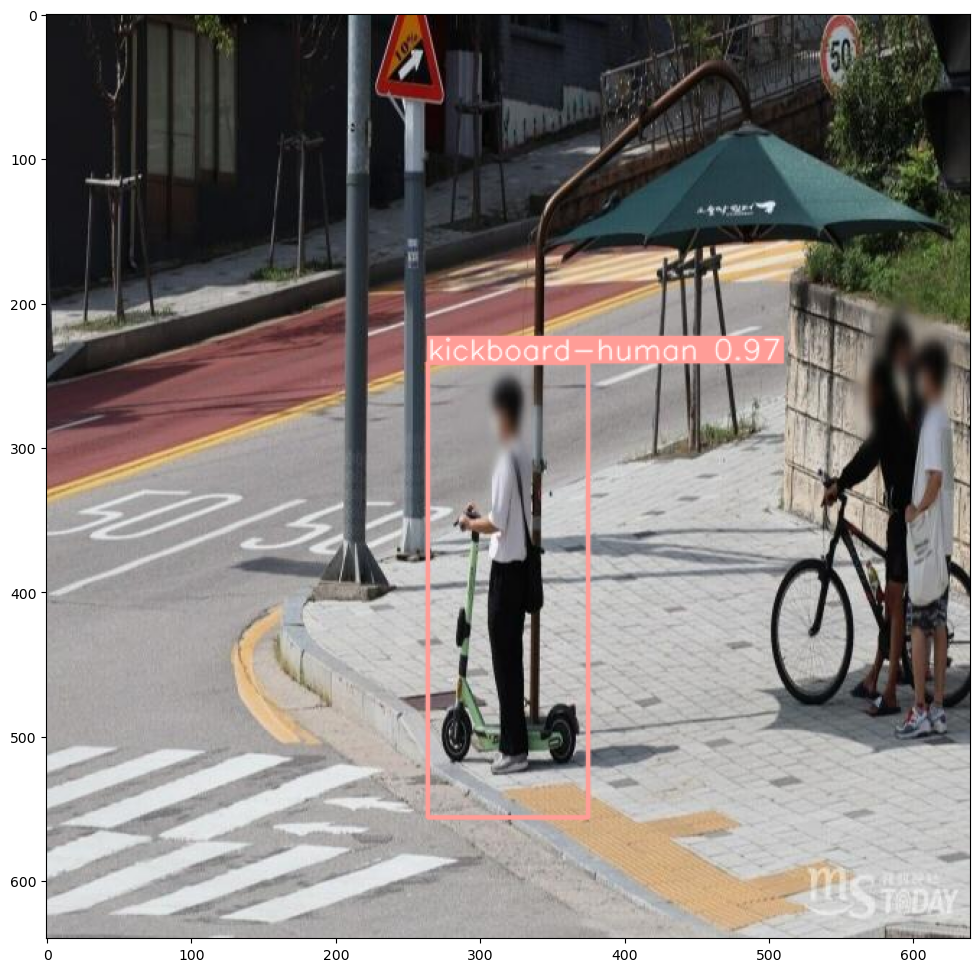

In [32]:
import os
import glob
import argparse
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO  # 가정한 모듈명, 실제로는 해당하는 YOLO 모듈로 대체해야 함
import cv2


# 모델 인스턴스 생성
model = MobileNetV2_UNet(num_classes=4)  # 클래스 수에 맞게 조정해야 할 수 있습니다.

# 모델을 CPU나 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 모델 가중치 로드 (학습된 모델 가중치 경로 지정 필요)
model.load_state_dict(torch.load('/home/pjs/workspace/best_model.pth', map_location=device))

# 모델을 평가 모드로 설정
model.eval()

def mask_to_color_image(mask):
    """예측된 마스크를 색상 이미지로 변환합니다."""
    # 클래스별 색상 정의: 0 - 검정, 1 - 빨강, 2 - 파랑, 3 - 노랑
    colors = np.array([
        [0, 0, 0],       # 검정
        [255, 0, 0],     # 빨강
        [0, 0, 255],     # 파랑
        [255, 255, 0]    # 노랑
    ], dtype=np.uint8)

    # 예측된 마스크의 각 픽셀에 대응하는 색상으로 변환
    color_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
    for class_idx in range(4):
        color_mask[mask[0] == class_idx] = colors[class_idx]

    return color_mask

# 예측된 마스크 이미지를 저장할 폴더 경로
predicted_folder_path = '/home/pjs/workspace/SEJONG_SAMPLE/predicted Mask'

# 폴더가 없으면 생성
if not os.path.exists(predicted_folder_path):
    os.makedirs(predicted_folder_path)

def visualize_prediction_with_image(model, image_path, device):
    # 이미지 전처리 및 모델을 통한 예측
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((960, 544)),  # 모델 입력 크기에 맞춰 조정 (필요에 따라 조정)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # 모델 예측
    with torch.no_grad():
        output = model(image_tensor)
        output = F.interpolate(output, size=image.size[::-1], mode='bilinear', align_corners=False)
        predicted_mask = torch.argmax(output, dim=1).cpu()  # 예측된 마스크

    # 원본 이미지 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # 예측된 마스크를 색상 이미지로 변환
    color_mask = mask_to_color_image(predicted_mask.numpy())

    # 예측된 색상 마스크 시각화
    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

    
    # 예측된 마스크 이미지 저장
    predicted_mask_image_path = os.path.join(predicted_folder_path, os.path.basename(image_path).replace('.jpg', '_predicted_mask.png'))
    plt.savefig(predicted_mask_image_path)
    plt.close()  # 현재의 figure를 닫아 다음 시각화를 위해 초기화
    



# 시각화 실행
image_path = '/home/pjs/workspace/SEJONG/bicycle-human-3/train/images/10_jpg.rf.867d4ab7685fb3d993b0a1b6774bdcf9.jpg'  # 시각화할 이미지 경로
visualize_prediction_with_image(model, image_path, device)

from ultralytics import YOLO

# Load the trained YOLO model with custom weights from 'best.pt'
model_yolo = YOLO('/home/pjs/workspace/SEJONG/realrun/detect/train37/weights/best.pt')
# 객체 탐지
results = model_yolo(image_path)

# 결과 출력
res_plotted = results[0].plot()

plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.show()



In [33]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([81.])
conf: tensor([0.9680])
data: tensor([[264.3892, 241.5376, 375.9482, 556.4645,   0.9680,  81.0000]])
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[320.1687, 399.0011, 111.5590, 314.9269]])
xywhn: tensor([[0.5003, 0.6234, 0.1743, 0.4921]])
xyxy: tensor([[264.3892, 241.5376, 375.9482, 556.4645]])
xyxyn: tensor([[0.4131, 0.3774, 0.5874, 0.8695]])

In [34]:
xywh_tensor = results[0].boxes.xywh

# 중심 좌표를 추출합니다.
x_center = xywh_tensor[0][0].item()
y_center = xywh_tensor[0][1].item()
width = xywh_tensor[0][2].item()
height = xywh_tensor[0][3].item()

# 중심에서 바닥으로 절반 내린 지점의 y 좌표를 계산합니다.
y_lower_half = y_center + (height / 2)

# 결과 좌표를 반환합니다.
result_coordinates = (x_center, y_lower_half)
result_coordinates

(320.1686706542969, 556.4645385742188)

In [35]:

import numpy as np
from PIL import Image

# 마스크 이미지 로드
mask_image_path = '/home/pjs/workspace/predicted Mask/predicted_mask.png'
mask_image = Image.open(mask_image_path)
mask_array = np.array(mask_image)

# 마스크 이미지가 RGBA라면, 알파 채널 제거
if mask_array.shape[2] == 4:
    mask_array = mask_array[..., :3]

# 해당 좌표의 픽셀 값 확인
pixel_value = mask_array[y_lower_half_int, x_center_int]

# 해당 좌표의 픽셀이 파란색인지 확인
is_in_blue_area = np.all(pixel_value == blue_value)

# 이미지에서 파란색 부분에 해당하는 값 (예: RGB에서 파란색은 (0, 0, 255))
blue_value = [0, 0, 255]  # 실제 마스크의 파란색 값을 기준으로 설정하세요

# 사람의 좌표를 기반으로 바닥 지점 계산
x_center = xywh_tensor[0][0].item()
y_center = xywh_tensor[0][1].item()
width = xywh_tensor[0][2].item()
height = xywh_tensor[0][3].item()
y_lower_half = y_center + (height / 2)

# 좌표가 정수가 되도록 반올림
x_center_int = int(round(x_center))
y_lower_half_int = int(round(y_lower_half))

# 해당 좌표의 픽셀 값 확인
# mask_array의 shape가 (height, width, channels)인지 확인하세요.
pixel_value = mask_array[y_lower_half_int, x_center_int]

# 해당 좌표의 픽셀이 파란색인지 확인
is_in_blue_area = np.all(pixel_value == blue_value)

# 결과 출력
print(f"The person at ({x_center}, {y_lower_half})")

if not is_in_blue_area:
    print("The person is jaywalking")
else:
    print("The person is a normal pedestrian.")




FileNotFoundError: [Errno 2] No such file or directory: '/home/pjs/workspace/predicted Mask/predicted_mask.png'

In [20]:
import os
import glob
import argparse
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO  # 가정한 모듈명, 실제로는 해당하는 YOLO 모듈로 대체해야 함
import cv2

# 인자 파싱을 위한 설정
parser = argparse.ArgumentParser(description='모델 실행을 위한 인자 파싱')
parser.add_argument('--data_dir', required=True, help='이미지 폴더 경로를 입력하세요.')
parser.add_argument('--result_dir', required=True, help='분석 결과가 저장될 폴더 경로를 입력하세요.')
args = parser.parse_args()



# 모델 인스턴스 생성
model = MobileNetV2_UNet(num_classes=4)  # 클래스 수에 맞게 조정해야 할 수 있습니다.

# 모델을 CPU나 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 모델 가중치 로드 (학습된 모델 가중치 경로 지정 필요)
model.load_state_dict(torch.load(os.path.join(args.data_dir, 'best_model.pth'), map_location=device))

# 모델을 평가 모드로 설정
model.eval()

def mask_to_color_image(mask):
    """예측된 마스크를 색상 이미지로 변환합니다."""
    # 클래스별 색상 정의: 0 - 검정, 1 - 빨강, 2 - 파랑, 3 - 노랑
    colors = np.array([
        [0, 0, 0],       # 검정
        [255, 0, 0],     # 빨강
        [0, 0, 255],     # 파랑
        [255, 255, 0]    # 노랑
    ], dtype=np.uint8)

    # 예측된 마스크의 각 픽셀에 대응하는 색상으로 변환
    color_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
    for class_idx in range(4):
        color_mask[mask[0] == class_idx] = colors[class_idx]

    return color_mask

def visualize_prediction_with_image(model, image_path, device):
    # 이미지 전처리 및 모델을 통한 예측
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((960, 544)),  # 모델 입력 크기에 맞춰 조정 (필요에 따라 조정)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # 모델 예측
    with torch.no_grad():
        output = model(image_tensor)
        output = F.interpolate(output, size=image.size[::-1], mode='bilinear', align_corners=False)
        predicted_mask = torch.argmax(output, dim=1).cpu()  # 예측된 마스크

    # 원본 이미지 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # 예측된 마스크를 색상 이미지로 변환
    color_mask = mask_to_color_image(predicted_mask.numpy())

    # 예측된 색상 마스크 시각화
    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# 시각화 실행
image_path = glob.glob(os.path.join(args.data_dir, '*.jpg'))[0]  # 첫 번째 JPG 이미지 경로
visualize_prediction_with_image(model, image_path, device)

# YOLO 모델 로드 및 객체 탐지 실행
model_yolo = YOLO(os.path.join(args.data_dir, 'best.pt'))
results = model_yolo(image_path)
res_plotted = results[0].plot()

# 결과 이미지 저장
result_image_path = os.path.join(args.result_dir, 'detection_result.jpg')
cv2.imwrite(result_image_path, cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

# 결과 이미지 출력
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



usage: ipykernel_launcher.py [-h] --data_dir DATA_DIR --result_dir RESULT_DIR
ipykernel_launcher.py: error: the following arguments are required: --data_dir, --result_dir


SystemExit: 2

/home/pjs/anaconda3/envs/XGBOOST/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
